# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Site

In [2]:
# The generic site class
Site = type(
    "Site",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.Locatable,  # Add coordinates to extract distance information and visualize
        core.HasContainer,  # Add information on the material available at the site
        core.HasResource,
    ),  # Add information on serving equipment
    {},
)  # The dictionary is empty because the site type is generic

# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Winlocatie",  # The name of the site
    "ID": "6dbbbdf4-4589-11e9-a501-b469212bff5d",  # For logging purposes
    "geometry": location_from_site,  # The coordinates of the project site
    "capacity": 100,  # The capacity of the site
    "level": 50,
}  # The actual volume of the site

# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)  # lon, lat

data_to_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Dumplocatie",  # The name of the site
    "ID": "6dbbbdf5-4589-11e9-82b2-b469212bff5c",  # For logging purposes
    "geometry": location_to_site,  # The coordinates of the project site
    "capacity": 50,  # The capacity of the site
    "level": 0,
}  # The actual volume of the site (empty of course)

# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site = Site(**data_to_site)

## Definition of Vessels

In [3]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.ContainerDependentMovable,  # A moving container, so capacity and location
        core.Processor,  # Allow for loading and unloading
        core.HasResource,  # Add information on serving equipment
        core.LoadingFunction,  # Add a loading function
        core.UnloadingFunction,  # Add an unloading function
    ),
    {},
)

# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: 10

# TSHD variables
data_hopper = {
    "env": my_env,  # The simpy environment
    "name": "Hopper 01",  # Name
    "ID": "6dbbbdf6-4589-11e9-95a2-b469212bff5b",  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 0.00001,  # Loading rate
    "unloading_rate": 0.00001,  # Unloading rate
    "capacity": 4,  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}

hopper = TransportProcessingResource(**data_hopper)

## Defenition of the activities

## Definition of process

In [4]:
single_run = []

move_activity_to_harbor_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing empty",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff5d",  # For logging purposes
    "registry": registry,
    "mover": hopper,
    "destination": from_site,
    "postpone_start": True,
}
single_run.append(model.MoveActivity(**move_activity_to_harbor_data))

shift_amount_activity_loading_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer MP",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff52",  # For logging purposes
    "registry": registry,
    "processor": hopper,
    "origin": from_site,
    "destination": hopper,
    "amount": 4,
    "duration": 1000,
    "postpone_start": True,
}
single_run.append(model.ShiftAmountActivity(**shift_amount_activity_loading_data))

move_activity_to_site_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing filler",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff5b",  # For logging purposes
    "registry": registry,
    "mover": hopper,
    "destination": to_site,
    "postpone_start": True,
}
single_run.append(model.MoveActivity(**move_activity_to_site_data))

shift_amount_activity_unloading_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer TP",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff54",  # For logging purposes
    "registry": registry,
    "processor": hopper,
    "origin": hopper,
    "destination": to_site,
    "amount": 4,
    "duration": 1000,
    "postpone_start": True,
}
single_run.append(model.ShiftAmountActivity(**shift_amount_activity_unloading_data))

basic_activity_data = {
    "env": my_env,
    "name": "Basic activity",
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff5h",  # For logging purposes
    "registry": registry,
    "duration": 0,
     "additional_logs": [hopper],
    "postpone_start": True,
}
single_run.append(model.BasicActivity(**basic_activity_data))


sequential_activity_data = {
    "env": my_env,
    "name": "Single run process",
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff60",  # For logging purposes
    "registry": registry,
    "sub_processes": single_run,
    "postpone_start": True,
}
activity = model.SequentialActivity(**sequential_activity_data)

expr = [{"type":"container", "concept": to_site, "state":"full"}]
while_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "while",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff5g",  # For logging purposes
    "registry": registry,
    "sub_process": activity,
    # "condition_event": [from_site.container.get_empty_event, to_site.container.get_full_event],
    #"condition_event": to_site.container.get_full_event,
    "condition_event": expr,
    "postpone_start": False,
}
while_activity = model.WhileActivity(**while_data)


In [5]:
my_env.run()

In [6]:
plot.get_log_dataframe(hopper, [while_activity, *single_run, activity])

,Timestamp,Activity,ActivityState,geometry,container level
0,1970-01-01 00:00:00.000000,sailing empty,START,POINT (4.18055556 52.18664444),0.0
1,1970-01-01 00:00:00.000000,sailing empty,STOP,POINT (4.18055556 52.18664444),0.0
2,1970-01-01 00:00:00.000000,Transfer MP,START,POINT (4.18055556 52.18664444),0.0
3,1970-01-01 00:00:00.000000,Transfer MP,START,POINT (4.18055556 52.18664444),0.0
4,1970-01-01 00:16:40.000000,Transfer MP,STOP,POINT (4.18055556 52.18664444),4.0
...,...,...,...,...,...
177,1970-01-01 13:29:30.614782,Transfer TP,START,POINT (4.25222222 52.11428333),0.0
178,1970-01-01 13:46:10.614782,Transfer TP,STOP,POINT (4.25222222 52.11428333),0.0
179,1970-01-01 13:46:10.614782,Transfer TP,STOP,POINT (4.25222222 52.11428333),0.0
180,1970-01-01 13:46:10.614782,Basic activity,START,POINT (4.25222222 52.11428333),0.0


In [7]:
 plot.vessel_planning([hopper, from_site, to_site])

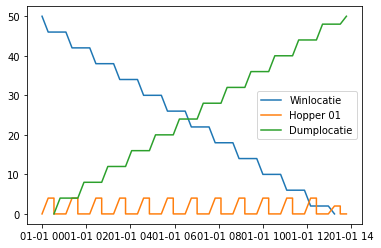

In [8]:
fig = plot.get_step_chart([from_site, hopper, to_site])